In [1]:
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
# pyunlocbox
from pyunlocbox import functions
from pyunlocbox import solvers

In [2]:
proj_data = scipy.io.loadmat(os.path.join("data", "project_data.mat"))
#A90 = scipy.io.loadmat('data/A90.mat')
#A90 = A90['A']
#A270 = scipy.io.loadmat('data/A90.mat')
Afull = scipy.io.loadmat('../A.mat')
Afull = Afull['A']
#sino90 = scipy.io.loadmat('data/Sinogram90.mat')
#sino90 = sino90['sinogram90']
sinofull = proj_data['sinogram']
sinofull_flat = np.transpose(sinofull.flatten(order = 'F'))
#sino90_flat = np.transpose(sino90.flatten(order = 'F'))

We can formulate the reconstrucion from the sinogram as an optimization problem as following:
$$
min_x ||A(x) - b||^2 + 2 \lambda ||x||_{TV}
$$
The formulation of the optimization problem follows the theoretical framework layed out in citation. First we consider the sinogram data. Let $b \in \mathbb{R}^{mxn}$ be the measured sinogram, where $n$ is the number of x-ray sources and $m$ is the number of angles. $x \in \mathbb{R}^{256^2 X 1}$ be the flattened true image with the resolution of 256X256. A is an affine map representing an operator and $\eta$ is a corresponding additive nuknown noise satistifying the additive relation (expand on the sources of noise).

## Regularization parameter search

It is a little difficult to implement a L curve, because it is not obvious how to get the misfit from the black box code.

But the soft start idea is implementable.



In [3]:
# Select a list of regularization parameters for 
lambdas = [0.1,1,10,100,1000,5000,10000,25000, 50000, 75000, 100000]
results = {}
n_pixels = np.product(proj_data["imgref"].shape)
model_init = np.zeros(n_pixels)

for lambda_ in lambdas:
    f1 = functions.norm_tv(maxit=50, dim=1)    
    f2 = functions.norm_l2(y=sinofull_flat, A=Afull,lambda_=lambda_ )
    solver = solvers.forward_backward(step=0.5/lambda_ )
    #solver = solvers.douglas_rachford(step=0.1)
    ret = solvers.solve([f1, f2], list(model_init), solver, rtol = 1e-6, maxit=1000)
    model_init = ret['sol']
    results[lambda_] = model_init

/Users/siqizhao/miniconda3/lib/python3.7/site-packages/pyunlocbox/functions.py:701: RuntimeWarning: invalid value encountered in double_scalars
  rel_obj = np.abs(obj - prev_obj) / obj


Solution found after 293 iterations:
    objective function f(sol) = 2.462974e+04
    stopping criterion: RTOL
Solution found after 169 iterations:
    objective function f(sol) = 3.086090e+04
    stopping criterion: RTOL
Solution found after 397 iterations:
    objective function f(sol) = 5.064175e+04
    stopping criterion: RTOL
Solution found after 643 iterations:
    objective function f(sol) = 1.317519e+05
    stopping criterion: RTOL
Solution found after 1000 iterations:
    objective function f(sol) = 6.817886e+05
    stopping criterion: MAXIT
Solution found after 1000 iterations:
    objective function f(sol) = 2.884789e+06
    stopping criterion: MAXIT
Solution found after 1 iterations:
    objective function f(sol) = 5.601528e+06
    stopping criterion: RTOL
Solution found after 1 iterations:
    objective function f(sol) = 1.375174e+07
    stopping criterion: RTOL
Solution found after 1 iterations:
    objective function f(sol) = 2.733540e+07
    stopping criterion: RTOL
Sol

In [4]:
num_iter = [293,169,397,643,681,1000,1,1,1,1,1]

0.1
1
10
100
1000
5000
10000
25000
50000
75000
100000


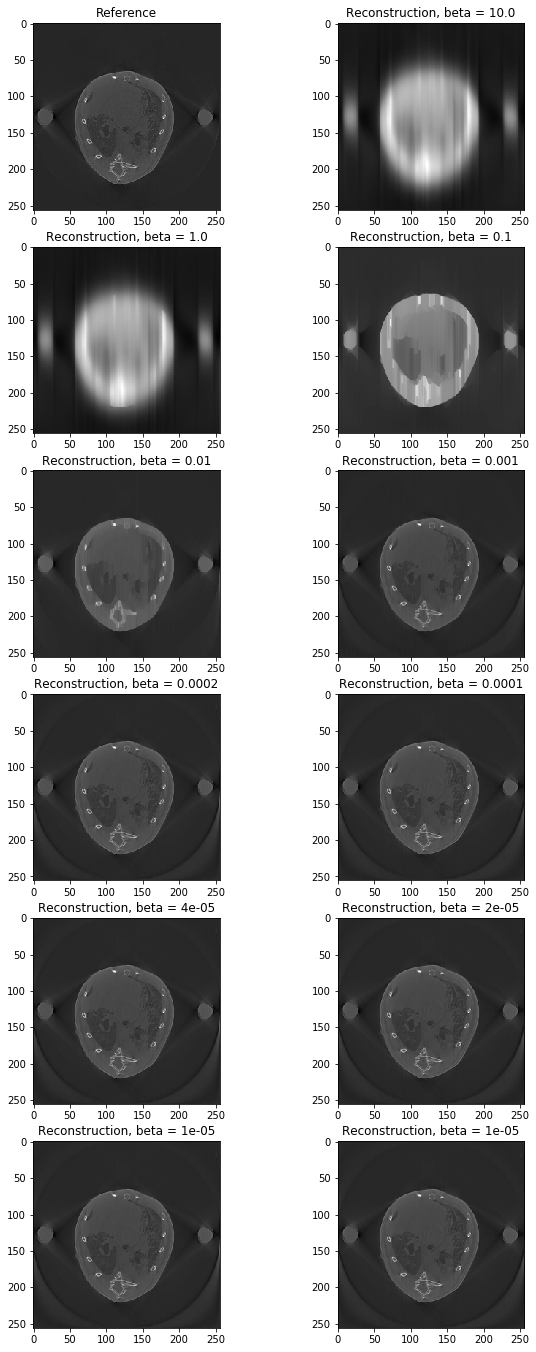

In [158]:
fig, axs = plt.subplots(ncols=2, nrows =6, figsize = (10,24))
axs = axs.ravel()
axs[0].imshow(proj_data["imgref"], cmap="gray")
axs[0].set_title("Reference")
for i, lambda_ in enumerate(lambdas):
    print(lambda_)
    model_mat = results[lambda_].reshape(proj_data["imgref"].shape, order="F")
    #np.savetxt(f'./results/tv_full_beta_{round(1/lambda_, 5)}.txt',model_mat)
    axs[i+1].imshow(model_mat, cmap="gray")
    axs[i+1].set_title(f"Reconstruction, beta = {round(1/lambda_, 5)}")
#plt.savefig('TV_reconstruction.png', dpi = 300)

In [14]:
misfits = []
regs = []
for lambda_ in lambdas:
    m_i = results[lambda_]
    f_l2 = functions.norm_l2()
    f_tv = functions.norm_tv(maxiter = 50, dim = 1)
    misfit = f_l2.eval(Afull.dot(m_i) - sinofull_flat)
    reg = f_tv.eval(m_i)
    misfits.append(misfit)
    regs.append(reg)

    norm_tv evaluation: 2.391986e+04
    norm_tv evaluation: 2.406267e+04
    norm_tv evaluation: 3.444890e+04
    norm_tv evaluation: 5.744061e+04
    norm_tv evaluation: 1.108032e+05
    norm_tv evaluation: 1.680472e+05
    norm_tv evaluation: 1.680480e+05
    norm_tv evaluation: 1.680500e+05
    norm_tv evaluation: 1.680529e+05
    norm_tv evaluation: 1.680564e+05
    norm_tv evaluation: 1.680603e+05


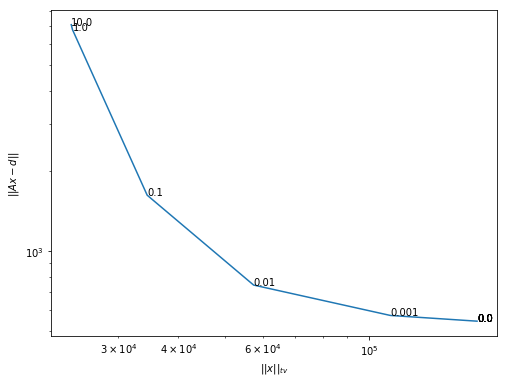

In [36]:
fig, ax = plt.subplots(figsize = (8,6))
plt.loglog(regs, misfits)
#plt.plot(regs, misfits)
for i, txt in enumerate(lambdas):
    ax.annotate(round(1/txt, 3), (regs[i], misfits[i]))
plt.xlabel(r'$||x||_{tv}$')
plt.ylabel(r'$||Ax - d||$')
#plt.savefig('tv_lcurve.png', dpi = 300)